In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import model_selection

In [2]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
RESULT_EXAMPLE_PATH = 'submission_example.csv'
RESULT_PATH = 'submission.csv'

In [3]:
df = pd.read_csv(TRAIN_PATH)
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [4]:
X_train = df[df.columns.drop(['Id', 'mean_exam_points'])].to_numpy()
y_train = df['mean_exam_points'].to_numpy()

In [5]:
class Node:
    
    def __init__(self, column, t, true_branch, false_branch):
        self.column = column
        self.t = t 
        self.true_branch = true_branch
        self.false_branch = false_branch

In [6]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels 
        self.prediction = self.predict() 
        
    def predict(self):
        return np.mean(self.labels)

In [7]:
def predict_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.column] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

In [8]:
def predict(data, tree):
    
    return [predict_object(obj, tree) for obj in data]

In [9]:
def tree_vote(forest, data):
# В качестве итогового предсказания берётся среднее по всем деревьям.
    return np.mean([predict(data, tree) for tree in forest], axis=0)

In [10]:
def accuracy_metric(actual, predicted):
    # Метрика точности предсказания (r2_score)
    _actual = np.array(actual)
    _predicted = np.array(predicted)

    ss_res = sum((_actual - _predicted) ** 2)
    ss_tot = sum((_actual - _actual.mean()) ** 2)

    return 1 - ss_res / ss_tot

In [11]:
def inf_criteria(labels):
# Расчет критерия информативности H(X)    
    return np.inf if len(labels) == 0 else np.var(labels, ddof=1)

In [12]:
def quality(left_labels, right_labels, current_inf_criteria):
# Расчет функционала качества
    # доля выборки, ушедшей в левое поддерево
    p = float(len(left_labels)) / (len(left_labels) + len(right_labels))
    
    return current_inf_criteria - p * inf_criteria(left_labels) - (1 - p) * inf_criteria(right_labels)

Для избежания корреляции моделей каждого дерева между собой, применим метод случайных подпространств.  
При обучении дерева в анализе использую часть имеющихся признаков.   
Для задачи регрессии принято брать n/3, для задач классификации $\sqrt{n}$.

In [13]:
def get_subsample(len_sample):

    sample_indexes = [i for i in range(len_sample)]
    np.random.shuffle(sample_indexes)

    len_subsample = int(len_sample / 3)
    subsample = sample_indexes[0:len_subsample].copy()
        
    return subsample

In [14]:
def split(data, labels, column, t):
    
    left = np.where(data[:, column] <= t)
    right = np.where(data[:, column] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [15]:
def find_best_split(data, labels):
    min_leaf = 5
    current_inf_criteria = inf_criteria(labels)

    best_quality = 0
    best_t = None
    best_column = None
    
    n_features = data.shape[1]

    subsample = get_subsample(n_features)
  
    for column in subsample:
        t_values = np.unique([row[column] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, column, t)

            current_quality = quality(true_labels, false_labels, current_inf_criteria)

            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            if current_quality > best_quality:
                best_quality, best_t, best_column = current_quality, t, column

    return best_quality, best_t, best_column

In [16]:
def build_tree(data, labels, max_depth, _depth=1):
# Построение дерева с помощью рекурсивной функции
    quality, t, column = find_best_split(data, labels)  

    if quality == 0 or _depth > max_depth: #  Базовый случай
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, column, t)

    true_branch = build_tree(true_data, true_labels, max_depth, _depth=_depth+1)
    false_branch = build_tree(false_data, false_labels, max_depth, _depth=_depth+1)

    return Node(column, t, true_branch, false_branch)

При построении случайного леса применяю бэггинг.  
Ошибку будем считать по данным, не входящим в бутстрап-выборку.  
Это даёт возможность не разбивать исходный датасет на тренировочный и тестовый.

In [17]:
def get_bootstrap(data, labels, N):
# Получение N бутстрап-выборок.
    n_samples = data.shape[0]
    bootstrap = []
    b_indexes = []

    for i in range(N):        
        sample_indexes = np.random.randint(n_samples, size=n_samples)
        bootstrap.append((data[sample_indexes], labels[sample_indexes]))
        b_indexes.append(sample_indexes)
        
    return bootstrap, b_indexes

In [18]:
def out_of_bag_score(data, labels, b_indexes, forest):
    predictions = []
    actual = []

    for i in range(data.shape[0]):

        index_tree = [] 
        for idx, b_index in enumerate(b_indexes):
            if i not in b_index: 
                index_tree.append(idx)

        if len(index_tree) != 0:
            new_forest = [forest[k] for k in index_tree] # новый лес на деревьях, которые не обучались на текущем наблюдении
            predictions.append(tree_vote(new_forest, [data[i]])[0]) # предсказание по текущему наблюдению
            actual.append(labels[i]) # истинное значение класса текущего наблюдения

    return accuracy_metric(actual, predictions)

In [19]:
def random_forest(data, labels, n_trees, max_depth):# Формирование случайного леса
    forest = []
    bootstrap, b_indexes = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, max_depth))
    
    oob_score = out_of_bag_score(data, labels, b_indexes, forest)

    return forest, oob_score

In [20]:
n_trees_arr = np.arange(1, 51, 1)
oob_scores = []

for n_trees in n_trees_arr:
    _, oob_score = random_forest(X_train, y_train, n_trees, max_depth=4)
    oob_scores.append(oob_score)

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


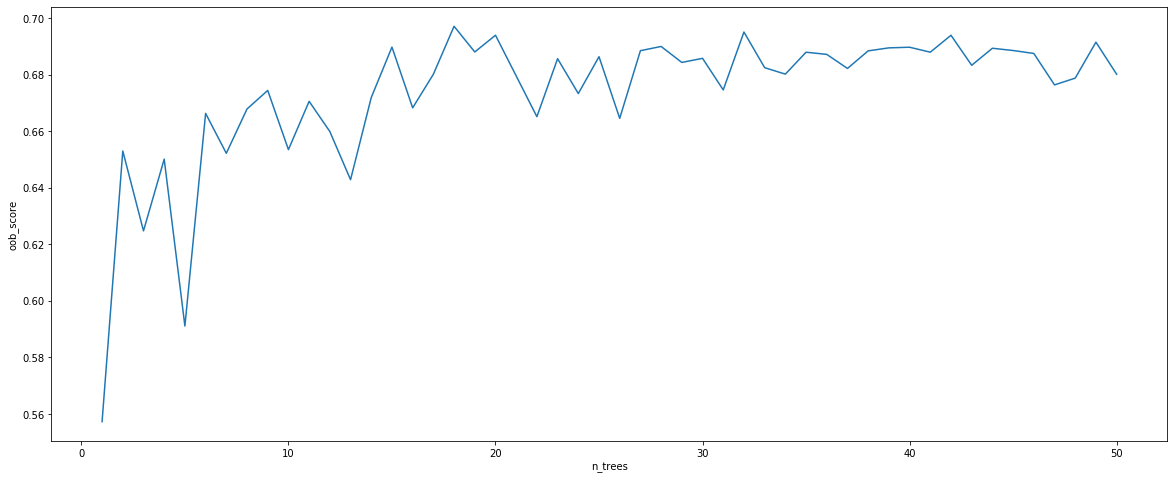

In [21]:
plt.figure(figsize=(20,8))
plt.plot(n_trees_arr, oob_scores)
plt.xlabel('n_trees')
plt.ylabel('oob_score')
plt.show()

In [22]:
max_depth_arr = np.arange(1, 20, 1)
oob_scores = []

for max_depth in max_depth_arr:
    _, oob_score = random_forest(X_train, y_train, 20, max_depth)
    oob_scores.append(oob_score)

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


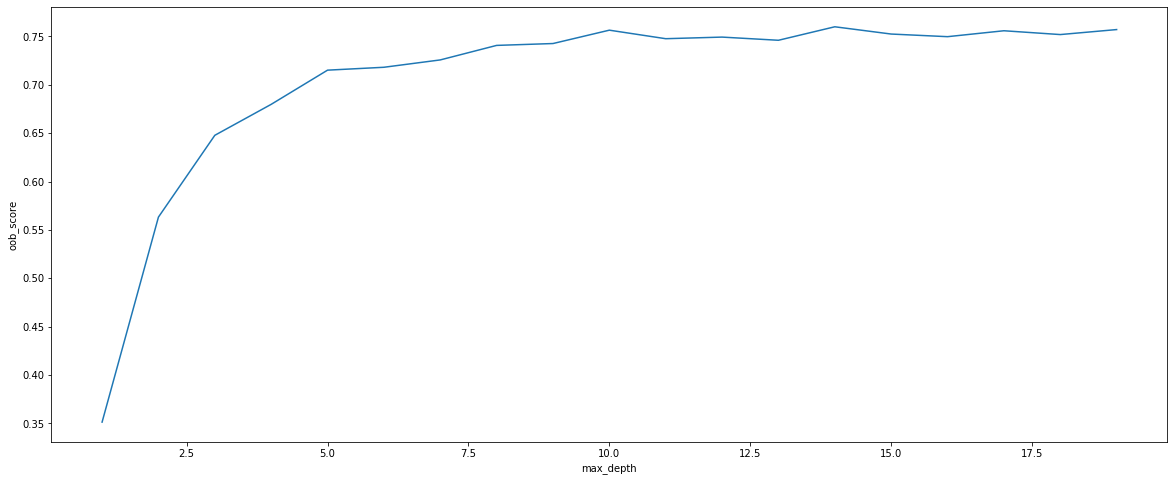

In [23]:
plt.figure(figsize=(20,8))
plt.plot(max_depth_arr, oob_scores)
plt.xlabel('max_depth')
plt.ylabel('oob_score')
plt.show()

По графикам примерно выбираем n_trees=18, max_depth=14.

In [25]:
n_trees = 18
max_depth = 14

forest, _ = random_forest(X_train, y_train, n_trees, max_depth)

По построенному лесу прогоним тестовые данные.

In [26]:
df_test = pd.read_csv(TEST_PATH)
X_test = df_test[df_test.columns.drop(['Id'])].to_numpy()
y_test = tree_vote(forest, X_test)

Сформируем итоговый файл с результатом.

In [27]:
ids = np.array(range(len(y_test), len(y_test) + len(y_test)))
submission = pd.DataFrame(data={ 'Id': ids, 'mean_exam_points': y_test })
submission.to_csv(RESULT_PATH, index=False)
submission.head()

,Id,mean_exam_points
0,10000,55.372195
1,10001,62.747036
2,10002,49.348712
3,10003,88.946477
4,10004,87.868127


Итог 62 место AVShipkov 0.77122